In [1]:
# Install dependencies
!pip install transformers datasets accelerate -q
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from google.colab import drive
drive.mount('/content/drive')


# Make sure ETSP directory is on the path for module imports
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ETSP/utils')
from prepare_dataset import make_datasets
# Disable WandB
os.environ["WANDB_DISABLED"] = "true"

# Set file path and dialects
file_path = '/content/drive/MyDrive/Colab Notebooks/ETSP/sentences_ch_de_transcribed.json'
dialects = ['ch_sg', 'ch_be', 'ch_gr', 'ch_zh', 'ch_vs', 'ch_bs', 'ch_ag', 'ch_lu']

# Load datasets and label mappings
train_dataset, val_dataset, test_dataset, dialect2label, _, _, _ = make_datasets(file_path, dialects)
label2dialect = {i: d for d, i in dialect2label.items()}

def add_label_text(example):
    example["label_text"] = label2dialect[example["label"]]
    return example

train_dataset = train_dataset.map(add_label_text)
val_dataset   = val_dataset.map(add_label_text)
test_dataset  = test_dataset.map(add_label_text)

Mounted at /content/drive


Map:   0%|          | 0/16184 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

In [2]:
# Print class distribution
train_df = pd.DataFrame(train_dataset)
val_df = pd.DataFrame(val_dataset)
test_df = pd.DataFrame(test_dataset)

print("Train distribution:")
print(train_df['label'].value_counts())
print("Validation distribution:")
print(val_df['label'].value_counts())
print("Test distribution:")
print(test_df['label'].value_counts())

Train distribution:
label
0    2023
1    2023
2    2023
3    2023
4    2023
5    2023
6    2023
7    2023
Name: count, dtype: int64
Validation distribution:
label
0    253
1    253
2    253
3    253
4    253
5    253
6    253
7    253
Name: count, dtype: int64
Test distribution:
label
0    253
1    253
2    253
3    253
4    253
5    253
6    253
7    253
Name: count, dtype: int64


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model_name = "google/byt5-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

def preprocess_function(examples):
    # Encode the input sentence
    model_inputs = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

    # Encode the target label text as the sequence to generate
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["label_text"],
            padding="max_length",
            truncation=True,
            max_length=8,  # label strings are short
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val   = val_dataset.map(preprocess_function, batched=True)
tokenized_test  = test_dataset.map(preprocess_function, batched=True)

# Set Torch format
for ds in [tokenized_train, tokenized_val, tokenized_test]:
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/16184 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

In [4]:
import numpy as np
from sklearn.metrics import classification_report

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # Decode predictions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Decode labels (replace -100 by pad_token_id first)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Strip spaces/newlines
    decoded_preds  = [p.strip() for p in decoded_preds]
    decoded_labels = [l.strip() for l in decoded_labels]

    # Map back to integer IDs; unknown → -1
    y_pred = [dialect2label.get(p, -1) for p in decoded_preds]
    y_true = [dialect2label[l]        for l in decoded_labels]

    # Optionally remove any -1 predictions (invalid labels)
    valid_idx = [i for i, yp in enumerate(y_pred) if yp != -1]
    y_pred = [y_pred[i] for i in valid_idx]
    y_true = [y_true[i] for i in valid_idx]

    report = classification_report(
        y_true,
        y_pred,
        target_names=list(label2dialect.values()),
        output_dict=True,
        zero_division=0,
    )

    metrics = {
        "accuracy": report["accuracy"],
        "macro_f1": report["macro avg"]["f1-score"],
    }
    return metrics


In [6]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./byt5-base",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    predict_with_generate=True,
    report_to="none",
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/transformers/data/data_collator.py:740: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.707900,0.261914,0.184289,0.122315
2,0.151900,0.101381,0.691700,0.697756
3,0.108500,0.080403,0.756917,0.760794


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=3036, training_loss=1.1319824408479673, metrics={'train_runtime': 6444.0598, 'train_samples_per_second': 7.534, 'train_steps_per_second': 0.471, 'total_flos': 2.1666627128918016e+16, 'train_loss': 1.1319824408479673, 'epoch': 3.0})

              precision    recall  f1-score   support

       ch_sg       0.72      0.67      0.69       253
       ch_be       0.94      0.81      0.87       253
       ch_gr       0.88      0.84      0.86       253
       ch_zh       0.59      0.77      0.67       253
       ch_vs       0.93      0.85      0.89       253
       ch_bs       0.64      0.68      0.66       253
       ch_ag       0.72      0.76      0.74       253
       ch_lu       0.76      0.69      0.72       253

    accuracy                           0.76      2024
   macro avg       0.77      0.76      0.76      2024
weighted avg       0.77      0.76      0.76      2024



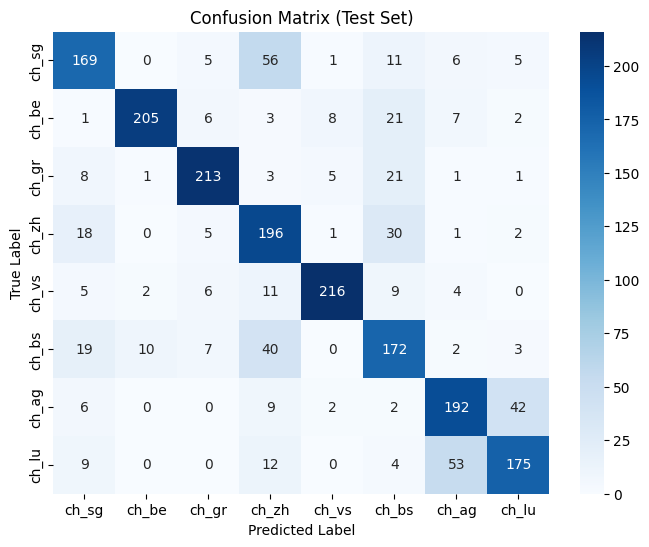

In [7]:
outputs = trainer.predict(tokenized_test)

pred_ids = outputs.predictions
label_ids = outputs.label_ids

decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
decoded_labels = tokenizer.batch_decode(
    np.where(label_ids != -100, label_ids, tokenizer.pad_token_id),
    skip_special_tokens=True,
)

decoded_preds  = [p.strip() for p in decoded_preds]
decoded_labels = [l.strip() for l in decoded_labels]

y_pred = [dialect2label.get(p, -1) for p in decoded_preds]
y_true = [dialect2label[l]        for l in decoded_labels]

# Optionally filter invalid predictions as above
valid_idx = [i for i, yp in enumerate(y_pred) if yp != -1]
y_pred = [y_pred[i] for i in valid_idx]
y_true = [y_true[i] for i in valid_idx]

print(classification_report(y_true, y_pred, target_names=list(label2dialect.values())))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(label2dialect.values()),
    yticklabels=list(label2dialect.values())
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()
